# Classification de locuteur : Chirac / Mitterrand 🇫🇷
<center><img src="src/miterrand_chirac.jpg" height="250"></center>

### Contenus:
* Analyse exploratoire des données.
* Traitement des données brutes:
    * Segmentation en mots (*Tokenization*).
    * Elimination des *stop-words*.
    * Stemming/lemmatisation (racinisation).
* Bag of Words.
* TF et IDF.
* Word2Vec.
* Classifieurs:
    * NB.
    * Regression Logistique.
    * SVM.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import codecs
import re
import os.path
import nltk

In [22]:
path_train = 'ressources/AFDpresidentutf8/corpus.tache1.learn.utf8'
path_test = 'ressources/AFDpresidentutf8/corpus.tache1.test.utf8'
path_test_lables = 'ressources/AFDpresidentutf8/ftlearn'

## Analyse exploratoire des données

Nous importons les données avec la fonction utilisée dans les notebooks du cours, qui utilise des expressions régulières pour extraire l'étiquette et le contenu.

In [23]:
def load_discours(fname):
    alltxts = []
    alllabs = []
    s = codecs.open(fname, 'r','utf-8')
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') > 0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts, alllabs

In [24]:
text, label = load_discours(path_train)

In [25]:
# Chirac ----> 1
# Mitterrand -> -1
print(len(text),len(label))
print(text[13])
print(label[13])
print(text[-1])
print(label[-1])

57413 57413
 Et ce sentiment n'est pas également partagé, monsieur le maire, mais enfin il existe de tous côtés.

-1
 Je compte sur vous.

1


Nous réorganisons l'ensemble de données dans un cadre de données pandas à des fins de visualisation.

In [26]:
df = pd.DataFrame({'text':text, 'label':label})
df.head()

,text,label
0,"Quand je dis chers amis, il ne s'agit pas là ...",1
1,D'abord merci de cet exceptionnel accueil que...,1
2,C'est toujours très émouvant de venir en Afri...,1
3,Aucun citoyen français ne peut être indiffére...,1
4,"Le Congo, que naguère le <nom> qualifia de ""r...",1


In [27]:
df.tail()

,text,label
57408,Je suis heureux de le mener avec vous.\n,1
57409,"Vous le savez, comme vous, j'ai la passion de...",1
57410,Je crois en son avenir.\n,1
57411,"Je crois en la politique, c'est-à-dire en not...",1
57412,Je compte sur vous.\n,1


Nous souhaitons compter le nombre de discours prononcés par chaque président, afin de vérifier si nous avons affaire à un ensemble de données équilibré.

/tmp/ipykernel_86093/3846337403.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df, palette=["#4C0099", "#FFB3B3"])


[Text(0, 0, 'Mitterand'), Text(1, 0, 'Chirac')]

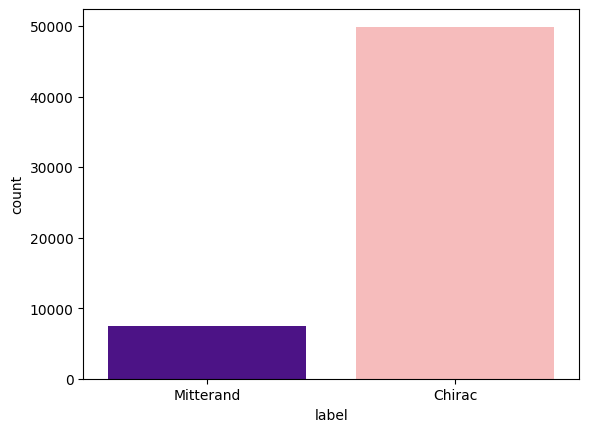

In [28]:
ax = sns.countplot(x='label', data=df, palette=["#4C0099", "#FFB3B3"])
ax.set_xticks([0,1])
ax.set_xticklabels(['Mitterand', 'Chirac'])

In [29]:
print(f'{len(df[df["label"]==-1])} phrases de Mitterand')
print(f'{len(df[df["label"]==1])} phrases de Chirac')

7523 phrases de Mitterand
49890 phrases de Chirac


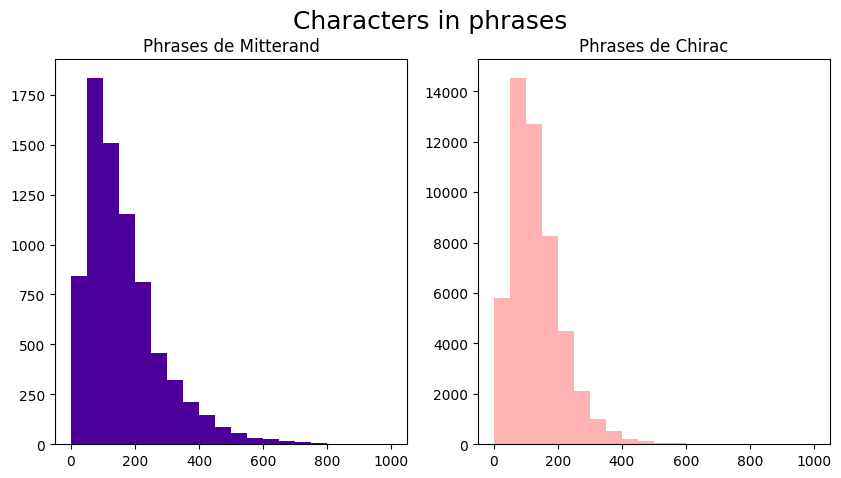

In [30]:
colors = ["#4C0099", "#FFB3B3"]

fig, axs=plt.subplots(1,2,figsize=(10,5))

chrt_count = df[df['label'] == -1]['text'].str.len()
axs[0].hist(chrt_count, color = colors[0], bins = 20, range = [0,1000])
axs[0].set_title('Phrases de Mitterand')

chrt_count = df[df['label'] == 1]['text'].str.len()
axs[1].hist(chrt_count, color = colors[1], bins = 20, range = [0,1000])
axs[1].set_title('Phrases de Chirac')

fig.suptitle('Characters in phrases', fontsize=18)
plt.show()

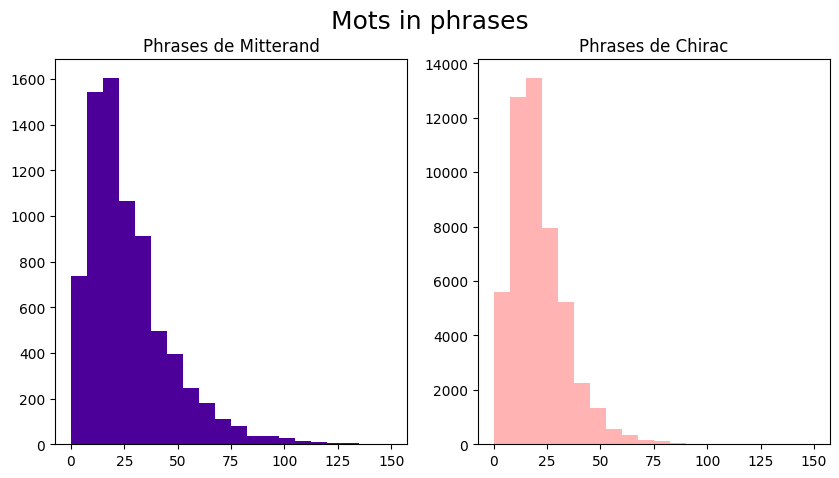

In [31]:
fig, axs=plt.subplots(1,2,figsize=(10,5))

mots_count = df[df['label'] == -1]['text'].str.split().map(lambda x: len(x))
axs[0].hist(mots_count, color = colors[0], bins = 20, range = [0,150])
axs[0].set_title('Phrases de Mitterand')

mots_count = df[df['label'] == 1]['text'].str.split().map(lambda x: len(x))
axs[1].hist(mots_count, color = colors[1], bins = 20, range = [0,150])
axs[1].set_title('Phrases de Chirac')

fig.suptitle('Mots in phrases', fontsize=18)
plt.show()

Pour conclure cette première étape, nous nous intéressons aux statistiques descriptives de l'ensemble des données et de chaque interlocuteur à l'échelle des mots.

In [32]:
print('\n------------------------',
      '\nPour toutes les phrases',
      '\n------------------------' ,
      f"\n{df['text'].str.split().map(lambda x: len(x)).describe()}")



------------------------ 
Pour toutes les phrases 
------------------------ 
count    57413.000000
mean        21.535610
std         14.336359
min          1.000000
25%         11.000000
50%         18.000000
75%         28.000000
max        386.000000
Name: text, dtype: float64


In [33]:
print('\n------------------------',
      '\n       Mitterand',
      '\n------------------------' ,
      f"\n{df[df['label'] == -1]['text'].str.split().map(lambda x: len(x)).describe()}")

print('\n------------------------',
      '\n        Chirac',
      '\n------------------------' ,
      f"\n{df[df['label'] == 1]['text'].str.split().map(lambda x: len(x)).describe()}")


------------------------ 
       Mitterand 
------------------------ 
count    7523.000000
mean       26.840755
std        19.784431
min         1.000000
25%        13.000000
50%        22.000000
75%        35.000000
max       297.000000
Name: text, dtype: float64

------------------------ 
        Chirac 
------------------------ 
count    49890.000000
mean        20.735638
std         13.138622
min          1.000000
25%         11.000000
50%         18.000000
75%         27.000000
max        386.000000
Name: text, dtype: float64


# Traitement des données brutes:

In [69]:
# nltk.download('stopwords')
# nltk.download('punkt')
import codecs
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

Afin de pouvoir explorer différentes options de prétraitement, nous créons une fonction unique qui effectue les opérations suivantes : 
* Supprimer la ponctuation et les majuscules.
* Supprimer les chiffres.
* Transformer les phrases en une liste de tokens.
* Lemmatiser.

Note : La bibliothèque FrenchLefffLemmatizer est utilisée, car la bibliothèque NLTK (Natural Lenguage Toolkit), classique pour les tâches de traitement automatique des langues, ne dispose pas d'un lemmatiseur robuste en français.

In [71]:
from matplotlib.pyplot import stem


stop_words = list(stopwords.words('french'))
print(stop_words)
lemmatizer = FrenchLefffLemmatizer()
stemmer = SnowballStemmer(language='french')

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

Nous définissons ensuite une fonction de prétraitement à l'échelle du corpus.

In [74]:
def PreprocessingCorpus(corpus, stop_words, lemmatizer, ap = True, pon = True, chif = True, stopw = True, lem = True, stem = True):
    preprocessed_tokens = []
    for phrase in corpus :
        if ap:
            new = re.sub(r'\b\w\'(?=\w)\b', '', phrase) # sans_appostrophe
        if pon:
            new = re.sub(r'[^\w\s]', '', new).lower() # sans_ponctuation
        if chif:
            new = ''.join([mot for mot in new if not mot.isdigit()]) # sans_chiffres

        new = nltk.tokenize.word_tokenize(new, language='french') # tokenize

        if stopw:
            new = [mot for mot in new if mot not in stop_words] # sans_stopwords
        if lem:
            new = [lemmatizer.lemmatize(mot) for mot in new] # lemmatize
        if stem:
            new = [stemmer.stem(mot) for mot in new]
        
        preprocessed_tokens.append(new)

    corpus = list()
    for phrase in preprocessed_tokens:
        corpus.append(' '.join(phrase))
        
    return corpus, preprocessed_tokens

In [75]:
preprocessed_corpus, tokenized = PreprocessingCorpus(text, stop_words, lemmatizer)

In [76]:
with open('results/preprocessed.txt', 'w') as fp:
    for i in preprocessed_corpus:
        fp.write("%s\n" % i)
    print('Done')

Done


## Bag of Words

### D'abord, on construit une classe pour calculer les valeaur d'accuracy, précision et rappel

In [77]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

class tableResults(object):
    def __init__(self) -> None:
        self.__results = {'Model': list(),'Accuracy_tr' : list(), 'Balanced_accuracy_tr' : list(),
                          'f1_tr' : list(), 'Accuracy_ts' : list(),'Balanced_accuracy_ts' : list(),
                          'f1_ts' : list()}
    
    def evaluer(self,methodeName, ytr, yts, yhat_tr, yhat_ts) -> None:
        acTr, bacTr, f1Tr, acTs, bacTs, f1Ts = (accuracy_score(ytr, yhat_tr),\
                                                            balanced_accuracy_score(ytr, yhat_tr),\
                                                            f1_score(ytr, yhat_tr),\
                                                            accuracy_score(yts, yhat_ts),\
                                                            balanced_accuracy_score(yts, yhat_ts),\
                                                            f1_score(yts, yhat_ts))
        metrics = [acTr, bacTr, f1Tr, acTs, bacTs, f1Ts]
        metrics_names = ['Accuracy_tr', 'Balanced_accuracy_tr', 'f1_tr',
                         'Accuracy_ts', 'Balanced_accuracy_ts', 'f1_ts']
        self.__results['Model'].append(methodeName)
        for name, metric in zip(metrics_names, metrics):
            self.__results[name].append(metric)   

        print (f'-----------------------------IN TRAIN DATA-------------------------\n\
               accuracy = {acTr}\n\
               balanced_accuracy = {bacTr}\n\
               f1 = {f1Tr}')
        print (f'-----------------------------IN TEST DATA--------------------------\n\
               accuracy = {acTs}\n\
               balanced_accuracy = {bacTs}\n\
               f1 = {f1Ts}')
    
    def afficher(self):
        return pd.DataFrame(self.__results)

In [78]:
resultats = tableResults()

In [79]:
from sklearn.feature_extraction.text import CountVectorizer

On commence pour faire des experiences afin de tester des approches naïves sur la regression logistique.

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [81]:
vectorizer = CountVectorizer(analyzer = 'word', ngram_range=(1, 1))
X = vectorizer.fit_transform(text)
y = np.array(label).squeeze()
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(57413, 28524)
(57413,)


In [82]:
logreg = LogisticRegression(class_weight = 'balanced', max_iter = 1000)
logreg.fit(X_train, y_train)
yhat_train = logreg.predict(X_train)
yhat_test = logreg.predict(X_test)
resultats.evaluer('naive1-LogisticRegression', y_train, y_test, yhat_train, yhat_test)
resultats.afficher()

-----------------------------IN TRAIN DATA-------------------------
               accuracy = 0.9357037995471398
               balanced_accuracy = 0.9463292372009435
               f1 = 0.9617796710448469
-----------------------------IN TEST DATA--------------------------
               accuracy = 0.8589758476544357
               balanced_accuracy = 0.7745071434219812
               f1 = 0.9164804181136746


,Model,Accuracy_tr,Balanced_accuracy_tr,f1_tr,Accuracy_ts,Balanced_accuracy_ts,f1_ts
0,naive1-LogisticRegression,0.935704,0.946329,0.96178,0.858976,0.774507,0.91648


In [83]:
vectorizer = CountVectorizer(stop_words=stop_words, analyzer = 'word', ngram_range=(1, 1))
X = vectorizer.fit_transform(text)
y = np.array(label).squeeze()
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(57413, 28400)
(57413,)


In [84]:
logreg = LogisticRegression(class_weight = 'balanced', max_iter = 1000)
logreg.fit(X_train, y_train)
yhat_train = logreg.predict(X_train)
yhat_test = logreg.predict(X_test)
resultats.evaluer('naive2-LogisticRegression', y_train, y_test, yhat_train, yhat_test)
resultats.afficher()

-----------------------------IN TRAIN DATA-------------------------
               accuracy = 0.9311751971932618
               balanced_accuracy = 0.9408412414646966
               f1 = 0.9590210080298674
-----------------------------IN TEST DATA--------------------------
               accuracy = 0.8472480260102183
               balanced_accuracy = 0.7576149462699903
               f1 = 0.909235174388519


,Model,Accuracy_tr,Balanced_accuracy_tr,f1_tr,Accuracy_ts,Balanced_accuracy_ts,f1_ts
0,naive1-LogisticRegression,0.935704,0.946329,0.961780,0.858976,0.774507,0.916480
1,naive2-LogisticRegression,0.931175,0.940841,0.959021,0.847248,0.757615,0.909235


Attention certains mots de la liste des stopwords nous font perdre des informations !

In [85]:
vectorizer = CountVectorizer(max_df = 0.0005, analyzer = 'word', ngram_range=(1, 1))
X = vectorizer.fit_transform(text)
y = np.array(label).squeeze()
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(57413, 25099)
(57413,)


In [86]:
logreg = LogisticRegression(class_weight = 'balanced', max_iter = 1000)
logreg.fit(X_train, y_train)
yhat_train = logreg.predict(X_train)
yhat_test = logreg.predict(X_test)
resultats.evaluer('naive3-LogisticRegression', y_train, y_test, yhat_train, yhat_test)
resultats.afficher()

-----------------------------IN TRAIN DATA-------------------------
               accuracy = 0.9112941352111275
               balanced_accuracy = 0.8633983559149864
               f1 = 0.9478412266455983
-----------------------------IN TEST DATA--------------------------
               accuracy = 0.8237923827217836
               balanced_accuracy = 0.6513703663393935
               f1 = 0.8972961997901933


,Model,Accuracy_tr,Balanced_accuracy_tr,f1_tr,Accuracy_ts,Balanced_accuracy_ts,f1_ts
0,naive1-LogisticRegression,0.935704,0.946329,0.961780,0.858976,0.774507,0.916480
1,naive2-LogisticRegression,0.931175,0.940841,0.959021,0.847248,0.757615,0.909235
2,naive3-LogisticRegression,0.911294,0.863398,0.947841,0.823792,0.651370,0.897296


À partir de là et sur la base de multiples expériences renforçant la découverte concernant les stop_words, il a été constaté que pour cet ensemble de données et pour la liste de stop_words proposée dans nltk, les performances de tous les modèles de classification proposés diminuent. Après avoir exploré le vocabulaire extrait à l'aide de la fonction `get_feature_names_out()`. Nous concluons que cela est dû au fait que la liste contient des mots qui peuvent aider à caractériser le ton d'un discours politique tels que : "pour" ou "nous".

Nous commençons maintenant à évaluer tous les modèles sur les données qui sont passées par notre fonction de prétraitement.

In [87]:
preprocessed_corpus, tokenized = PreprocessingCorpus(text, stop_words, lemmatizer, stopw = False)

In [89]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1))
X = vectorizer.fit_transform(preprocessed_corpus)
y = np.array(label).squeeze()
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(57413, 13643)
(57413,)


In [91]:
logreg = LogisticRegression(class_weight = 'balanced', max_iter = 1000)
logreg.fit(X_train, y_train)
yhat_train = logreg.predict(X_train)
yhat_test = logreg.predict(X_test)
resultats.evaluer('vectorizer1-LogisticRegression', y_train, y_test, yhat_train, yhat_test)
resultats.afficher()

-----------------------------IN TRAIN DATA-------------------------
               accuracy = 0.8928064893378785
               balanced_accuracy = 0.8994643018815788
               f1 = 0.9351575905355369
-----------------------------IN TEST DATA--------------------------
               accuracy = 0.8377844867626567
               balanced_accuracy = 0.7782526686210816
               f1 = 0.9021434575511348


,Model,Accuracy_tr,Balanced_accuracy_tr,f1_tr,Accuracy_ts,Balanced_accuracy_ts,f1_ts
0,naive1-LogisticRegression,0.935704,0.946329,0.961780,0.858976,0.774507,0.916480
1,naive2-LogisticRegression,0.931175,0.940841,0.959021,0.847248,0.757615,0.909235
2,naive3-LogisticRegression,0.911294,0.863398,0.947841,0.823792,0.651370,0.897296
3,vectorizer1-LogisticRegression,0.892806,0.899464,0.935158,0.837784,0.778253,0.902143
4,vectorizer1-LogisticRegression,0.892806,0.899464,0.935158,0.837784,0.778253,0.902143


In [ ]:
svc = SVC(class_weight = 'balanced')
svc.fit(X_train, y_train)
yhat_train = svc.predict(X_train)
yhat_test = svc.predict(X_test)
resultats.evaluer('vectorizer1-SVM', y_train, y_test, yhat_train, yhat_test)
resultats.afficher()

In [ ]:
rf = RandomForestClassifier(class_weight = 'balanced', max_depth=25, random_state=42)
rf.fit(X_train, y_train)
yhat_train = rf.predict(X_train)
yhat_test = rf.predict(X_test)

In [ ]:
resultats.evaluer('vectorizer1-RandomForest', y_train, y_test, yhat_train, yhat_test)
resultats.afficher()

Essayons maintenant d'autres options de prétraitement

In [126]:
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(1, 2), max_features=40000)
X = vectorizer2.fit_transform(preprocessed_corpus)
y = np.array(label).squeeze()
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(57413, 40000)
(57413,)


In [127]:
logreg = LogisticRegression(class_weight = 'balanced', max_iter = 1000)
logreg.fit(X_train, y_train)
yhat_train = logreg.predict(X_train)
yhat_test = logreg.predict(X_test)

In [128]:
resultats.evaluer('vectorizer2-LogisticRegression', y_train, y_test, yhat_train, yhat_test)
resultats.afficher()

-----------------------------IN TRAIN DATA-------------------------
               accuracy = 0.9808902933638558
               balanced_accuracy = 0.9862736816237594
               f1 = 0.9888818113382363
-----------------------------IN TEST DATA--------------------------
               accuracy = 0.8857408267533674
               balanced_accuracy = 0.7781784510940095
               f1 = 0.933661430593946


,Model,Accuracy_tr,Balanced_accuracy_tr,f1_tr,Accuracy_ts,Balanced_accuracy_ts,f1_ts
0,naive1-LogisticRegression,0.935704,0.946329,0.961780,0.858976,0.774507,0.916480
1,naive2-LogisticRegression,0.931175,0.940841,0.959021,0.847248,0.757615,0.909235
2,naive3-LogisticRegression,0.911294,0.863398,0.947841,0.823792,0.651370,0.897296
3,vectorizer1-LogisticRegression,0.892806,0.899464,0.935158,0.837784,0.778253,0.902143
4,vectorizer1-LogisticRegression,0.892806,0.899464,0.935158,0.837784,0.778253,0.902143
5,vectorizer2-LogisticRegression,0.980890,0.986274,0.988882,0.885741,0.778178,0.933661
6,vectorizer3-LogisticRegression,0.985618,0.989077,0.991655,0.888121,0.777245,0.935185
7,vectorizer3-LogisticRegression,0.975690,0.982079,0.985819,0.879645,0.777171,0.929812
8,vectorizer3-LogisticRegression,0.981363,0.986226,0.989161,0.884464,0.778020,0.932856
9,vectorizer3-LogisticRegression,0.981363,0.986226,0.989161,0.884464,0.778020,0.932856


In [42]:
svc = SVC(class_weight = 'balanced')
svc.fit(X_train, y_train)
yhat_train = svc.predict(X_train)
yhat_test = svc.predict(X_test)

In [43]:
resultats.evaluer('vectorizer2-SVM', y_train, y_test, yhat_train, yhat_test)
resultats.afficher()

-----------------------------IN TRAIN DATA-------------------------
               accuracy = 0.9712856751847521
               balanced_accuracy = 0.9713028439598625
               f1 = 0.983257406493921
-----------------------------IN TEST DATA--------------------------
               accuracy = 0.8756386437529029
               balanced_accuracy = 0.6772991923909095
               f1 = 0.9297336307571183


,Model,Accuracy_tr,Balanced_accuracy_tr,f1_tr,Accuracy_ts,Balanced_accuracy_ts,f1_ts
0,vectorizer1-LogisticRegression,0.929533,0.895021,0.958690,0.835752,0.691591,0.903805
1,vectorizer1-SVM,0.956804,0.914648,0.975040,0.859150,0.599974,0.921509
2,vectorizer1-RandomForest,0.903456,0.941034,0.941194,0.696993,0.657366,0.803390
3,vectorizer2-LogisticRegression,0.962378,0.966572,0.977946,0.868439,0.768055,0.922846
4,vectorizer2-SVM,0.971286,0.971303,0.983257,0.875639,0.677299,0.929734


In [131]:
rf = RandomForestClassifier(class_weight = 'balanced')
rf.fit(X_train, y_train)
yhat_train = rf.predict(X_train)
yhat_test = rf.predict(X_test)

In [132]:
resultats.evaluer('vectorizer2-RandomForest', y_train, y_test, yhat_train, yhat_test)
resultats.afficher()

-----------------------------IN TRAIN DATA-------------------------
               accuracy = 0.9076613003558187
               balanced_accuracy = 0.8000334138475341
               f1 = 0.9467842546784254
-----------------------------IN TEST DATA--------------------------
               accuracy = 0.8576405016256387
               balanced_accuracy = 0.7150823334566492
               f1 = 0.9173631706659477


,Model,Accuracy_tr,Balanced_accuracy_tr,f1_tr,Accuracy_ts,Balanced_accuracy_ts,f1_ts
0,naive1-LogisticRegression,0.935704,0.946329,0.961780,0.858976,0.774507,0.916480
1,naive2-LogisticRegression,0.931175,0.940841,0.959021,0.847248,0.757615,0.909235
2,naive3-LogisticRegression,0.911294,0.863398,0.947841,0.823792,0.651370,0.897296
3,vectorizer1-LogisticRegression,0.892806,0.899464,0.935158,0.837784,0.778253,0.902143
4,vectorizer1-LogisticRegression,0.892806,0.899464,0.935158,0.837784,0.778253,0.902143
5,vectorizer2-LogisticRegression,0.980890,0.986274,0.988882,0.885741,0.778178,0.933661
6,vectorizer3-LogisticRegression,0.985618,0.989077,0.991655,0.888121,0.777245,0.935185
7,vectorizer3-LogisticRegression,0.975690,0.982079,0.985819,0.879645,0.777171,0.929812
8,vectorizer3-LogisticRegression,0.981363,0.986226,0.989161,0.884464,0.778020,0.932856
9,vectorizer3-LogisticRegression,0.981363,0.986226,0.989161,0.884464,0.778020,0.932856


Testons les trois modèles avec une troisième approximation du sac de mots.

In [123]:
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(1, 3), max_features=50000)
X = vectorizer2.fit_transform(preprocessed_corpus)
y = np.array(label).squeeze()
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(57413, 50000)
(57413,)


In [103]:
logreg = LogisticRegression(class_weight = 'balanced', max_iter = 1000, random_state=42)
logreg.fit(X_train, y_train)
yhat_train = logreg.predict(X_train)
yhat_test = logreg.predict(X_test)
resultats.evaluer('vectorizer3-LogisticRegression', y_train, y_test, yhat_train, yhat_test)
resultats.afficher()

-----------------------------IN TRAIN DATA-------------------------
               accuracy = 0.9856179551618602
               balanced_accuracy = 0.9890766711865877
               f1 = 0.9916551166551166
-----------------------------IN TEST DATA--------------------------
               accuracy = 0.8881212261960055
               balanced_accuracy = 0.7772446122095211
               f1 = 0.9351854966196899


,Model,Accuracy_tr,Balanced_accuracy_tr,f1_tr,Accuracy_ts,Balanced_accuracy_ts,f1_ts
0,naive1-LogisticRegression,0.935704,0.946329,0.961780,0.858976,0.774507,0.916480
1,naive2-LogisticRegression,0.931175,0.940841,0.959021,0.847248,0.757615,0.909235
2,naive3-LogisticRegression,0.911294,0.863398,0.947841,0.823792,0.651370,0.897296
3,vectorizer1-LogisticRegression,0.892806,0.899464,0.935158,0.837784,0.778253,0.902143
4,vectorizer1-LogisticRegression,0.892806,0.899464,0.935158,0.837784,0.778253,0.902143
5,vectorizer2-LogisticRegression,0.980890,0.986274,0.988882,0.885741,0.778178,0.933661
6,vectorizer3-LogisticRegression,0.985618,0.989077,0.991655,0.888121,0.777245,0.935185
7,vectorizer3-LogisticRegression,0.975690,0.982079,0.985819,0.879645,0.777171,0.929812
8,vectorizer3-LogisticRegression,0.981363,0.986226,0.989161,0.884464,0.778020,0.932856
9,vectorizer3-LogisticRegression,0.981363,0.986226,0.989161,0.884464,0.778020,0.932856


In [124]:
rf = RandomForestClassifier(class_weight = 'balanced', random_state=42)
rf.fit(X_train, y_train)
yhat_train = rf.predict(X_train)
yhat_test = rf.predict(X_test)
resultats.evaluer('vectorizer3-RandomForest', y_train, y_test, yhat_train, yhat_test)
resultats.afficher()

-----------------------------IN TRAIN DATA-------------------------
               accuracy = 0.9998009405558735
               balanced_accuracy = 0.9994054058929231
               f1 = 0.9998853539696188
-----------------------------IN TEST DATA--------------------------
               accuracy = 0.8813864375290292
               balanced_accuracy = 0.5498637085412315
               f1 = 0.9360503333646352


,Model,Accuracy_tr,Balanced_accuracy_tr,f1_tr,Accuracy_ts,Balanced_accuracy_ts,f1_ts
0,naive1-LogisticRegression,0.935704,0.946329,0.961780,0.858976,0.774507,0.916480
1,naive2-LogisticRegression,0.931175,0.940841,0.959021,0.847248,0.757615,0.909235
2,naive3-LogisticRegression,0.911294,0.863398,0.947841,0.823792,0.651370,0.897296
3,vectorizer1-LogisticRegression,0.892806,0.899464,0.935158,0.837784,0.778253,0.902143
4,vectorizer1-LogisticRegression,0.892806,0.899464,0.935158,0.837784,0.778253,0.902143
5,vectorizer2-LogisticRegression,0.980890,0.986274,0.988882,0.885741,0.778178,0.933661
6,vectorizer3-LogisticRegression,0.985618,0.989077,0.991655,0.888121,0.777245,0.935185
7,vectorizer3-LogisticRegression,0.975690,0.982079,0.985819,0.879645,0.777171,0.929812
8,vectorizer3-LogisticRegression,0.981363,0.986226,0.989161,0.884464,0.778020,0.932856
9,vectorizer3-LogisticRegression,0.981363,0.986226,0.989161,0.884464,0.778020,0.932856


En examinant les résultats historiques, il est évident que notre forêt aléatoire sur-apprendre sur l'ensemble d'apprentissage. Compte tenu du temps d'exécution de chaque étape de ce projet, nous ne pouvons pas faire un selection exhaustive d'hyperparamètres, pour résoudre ce problème. Au lieu de cela, sur la base de la connaissance du fonctionnement mathématique de la méthode, nous diminuerons manuellement la profondeur de chaque arbre et analyserons les changements que cela apporte aux scores.

In [ ]:
rf = RandomForestClassifier(class_weight = 'balanced', max_depth=25, random_state=42)
rf.fit(X_train, y_train)
yhat_train = rf.predict(X_train)
yhat_test = rf.predict(X_test)
resultats.evaluer('vectorizer3-RandomForest', y_train, y_test, yhat_train, yhat_test)
resultats.afficher()

Nous avons réussi à combattre le sur-apprentissage, mais il semble que la régression logistique et la SVM soient plus prometteuses, c'est pourquoi nous arrêterons d'utiliser la méthode de la forêt aléatoire dans les prochaines itérations.

## TF-IDF

In [104]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

tf_idf = Pipeline([('count', CountVectorizer(analyzer='word', ngram_range=(1, 1))),
                 ('tfid', TfidfTransformer())])

X = tf_idf.fit_transform(preprocessed_corpus)
y = np.array(label).squeeze()
print(X.shape)
print(y.shape)

(57413, 13643)
(57413,)


In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [106]:
logreg = LogisticRegression(class_weight = 'balanced', random_state=42)
logreg.fit(X_train, y_train)
yhat_train = logreg.predict(X_train)
yhat_test = logreg.predict(X_test)

In [107]:
resultats.evaluer('tf_idf1-LogisticRegression', y_train, y_test, yhat_train, yhat_test)
resultats.afficher()

-----------------------------IN TRAIN DATA-------------------------
               accuracy = 0.8593645027246262
               balanced_accuracy = 0.8647645462488615
               f1 = 0.9136835675015272
-----------------------------IN TEST DATA--------------------------
               accuracy = 0.8251277287505806
               balanced_accuracy = 0.7840221363824158
               f1 = 0.8931839137527485


,Model,Accuracy_tr,Balanced_accuracy_tr,f1_tr,Accuracy_ts,Balanced_accuracy_ts,f1_ts
0,naive1-LogisticRegression,0.935704,0.946329,0.961780,0.858976,0.774507,0.916480
1,naive2-LogisticRegression,0.931175,0.940841,0.959021,0.847248,0.757615,0.909235
2,naive3-LogisticRegression,0.911294,0.863398,0.947841,0.823792,0.651370,0.897296
3,vectorizer1-LogisticRegression,0.892806,0.899464,0.935158,0.837784,0.778253,0.902143
4,vectorizer1-LogisticRegression,0.892806,0.899464,0.935158,0.837784,0.778253,0.902143
5,vectorizer2-LogisticRegression,0.980890,0.986274,0.988882,0.885741,0.778178,0.933661
6,vectorizer3-LogisticRegression,0.985618,0.989077,0.991655,0.888121,0.777245,0.935185
7,vectorizer3-LogisticRegression,0.975690,0.982079,0.985819,0.879645,0.777171,0.929812
8,vectorizer3-LogisticRegression,0.981363,0.986226,0.989161,0.884464,0.778020,0.932856
9,vectorizer3-LogisticRegression,0.981363,0.986226,0.989161,0.884464,0.778020,0.932856


In [108]:
svc = SVC(class_weight = 'balanced')
svc.fit(X_train, y_train)
yhat_train = svc.predict(X_train)
yhat_test = svc.predict(X_test)

In [109]:
resultats.evaluer('tf_idf1-SVM', y_train, y_test, yhat_train, yhat_test)
resultats.afficher()

-----------------------------IN TRAIN DATA-------------------------
               accuracy = 0.9874094901589987
               balanced_accuracy = 0.9926682326339157
               f1 = 0.9926954613696731
-----------------------------IN TEST DATA--------------------------
               accuracy = 0.8997909893172318
               balanced_accuracy = 0.7352535413520022
               f1 = 0.9432982917214192


,Model,Accuracy_tr,Balanced_accuracy_tr,f1_tr,Accuracy_ts,Balanced_accuracy_ts,f1_ts
0,naive1-LogisticRegression,0.935704,0.946329,0.961780,0.858976,0.774507,0.916480
1,naive2-LogisticRegression,0.931175,0.940841,0.959021,0.847248,0.757615,0.909235
2,naive3-LogisticRegression,0.911294,0.863398,0.947841,0.823792,0.651370,0.897296
3,vectorizer1-LogisticRegression,0.892806,0.899464,0.935158,0.837784,0.778253,0.902143
4,vectorizer1-LogisticRegression,0.892806,0.899464,0.935158,0.837784,0.778253,0.902143
5,vectorizer2-LogisticRegression,0.980890,0.986274,0.988882,0.885741,0.778178,0.933661
6,vectorizer3-LogisticRegression,0.985618,0.989077,0.991655,0.888121,0.777245,0.935185
7,vectorizer3-LogisticRegression,0.975690,0.982079,0.985819,0.879645,0.777171,0.929812
8,vectorizer3-LogisticRegression,0.981363,0.986226,0.989161,0.884464,0.778020,0.932856
9,vectorizer3-LogisticRegression,0.981363,0.986226,0.989161,0.884464,0.778020,0.932856


Nous ajoutons maintenant à `vectorize2`, le transformateur TF-IDF.

In [133]:
tf_idf = Pipeline([('count', CountVectorizer(analyzer='word', ngram_range=(1, 2), max_features=50000)),
                 ('tfid', TfidfTransformer())])

X = tf_idf.fit_transform(preprocessed_corpus)
y = np.array(label).squeeze()
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(57413, 50000)
(57413,)


In [134]:
logreg = LogisticRegression(class_weight = 'balanced', max_iter = 1000)
logreg.fit(X_train, y_train)
yhat_train = logreg.predict(X_train)
yhat_test = logreg.predict(X_test)
resultats.evaluer('tf_idf2-LogisticRegression', y_train, y_test, yhat_train, yhat_test)
resultats.afficher()

-----------------------------IN TRAIN DATA-------------------------
               accuracy = 0.9176391549926597
               balanced_accuracy = 0.9291253422004935
               f1 = 0.9506353278052855
-----------------------------IN TEST DATA--------------------------
               accuracy = 0.8682071528100325
               balanced_accuracy = 0.799550878964713
               f1 = 0.92182118749139


,Model,Accuracy_tr,Balanced_accuracy_tr,f1_tr,Accuracy_ts,Balanced_accuracy_ts,f1_ts
0,naive1-LogisticRegression,0.935704,0.946329,0.961780,0.858976,0.774507,0.916480
1,naive2-LogisticRegression,0.931175,0.940841,0.959021,0.847248,0.757615,0.909235
2,naive3-LogisticRegression,0.911294,0.863398,0.947841,0.823792,0.651370,0.897296
3,vectorizer1-LogisticRegression,0.892806,0.899464,0.935158,0.837784,0.778253,0.902143
4,vectorizer1-LogisticRegression,0.892806,0.899464,0.935158,0.837784,0.778253,0.902143
5,vectorizer2-LogisticRegression,0.980890,0.986274,0.988882,0.885741,0.778178,0.933661
6,vectorizer3-LogisticRegression,0.985618,0.989077,0.991655,0.888121,0.777245,0.935185
7,vectorizer3-LogisticRegression,0.975690,0.982079,0.985819,0.879645,0.777171,0.929812
8,vectorizer3-LogisticRegression,0.981363,0.986226,0.989161,0.884464,0.778020,0.932856
9,vectorizer3-LogisticRegression,0.981363,0.986226,0.989161,0.884464,0.778020,0.932856


In [59]:
svc = SVC(class_weight = 'balanced')
svc.fit(X_train, y_train)
yhat_train = svc.predict(X_train)
yhat_test = svc.predict(X_test)
resultats.evaluer('tf_idf2-SVM', y_train, y_test, yhat_train, yhat_test)
resultats.afficher()

-----------------------------IN TRAIN DATA-------------------------
               accuracy = 0.9936549802184678
               balanced_accuracy = 0.9960254872887011
               f1 = 0.9963324655898977
-----------------------------IN TEST DATA--------------------------
               accuracy = 0.9019391546679052
               balanced_accuracy = 0.7002566174495066
               f1 = 0.9452600875060768


,Model,Accuracy_tr,Balanced_accuracy_tr,f1_tr,Accuracy_ts,Balanced_accuracy_ts,f1_ts
0,vectorizer1-LogisticRegression,0.929533,0.895021,0.958690,0.835752,0.691591,0.903805
1,vectorizer1-SVM,0.956804,0.914648,0.975040,0.859150,0.599974,0.921509
2,vectorizer1-RandomForest,0.903456,0.941034,0.941194,0.696993,0.657366,0.803390
3,vectorizer2-LogisticRegression,0.962378,0.966572,0.977946,0.868439,0.768055,0.922846
4,vectorizer2-SVM,0.971286,0.971303,0.983257,0.875639,0.677299,0.929734
5,vectorizer2-RandomForest,0.998084,0.998656,0.998895,0.867685,0.550433,0.927932
6,tf-idf-LogisticRegression,0.914703,0.886639,0.949554,0.836856,0.696250,0.904376
7,tf_idf1-LogisticRegression,0.914703,0.886639,0.949554,0.836856,0.696250,0.904376
8,tf_idf1-LogisticRegression-SVM,0.899599,0.939852,0.938677,0.805098,0.621852,0.885913
9,tf_idf1-SVM,0.899599,0.939852,0.938677,0.805098,0.621852,0.885913


## Word2Vec